In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("/content"))

['.config', 'sample_submission.csv', 'train.csv', 'test.csv', 'sample_data']


In [3]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [4]:
X_train = train.drop(['label'], axis=1)
Y_train = train['label']

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

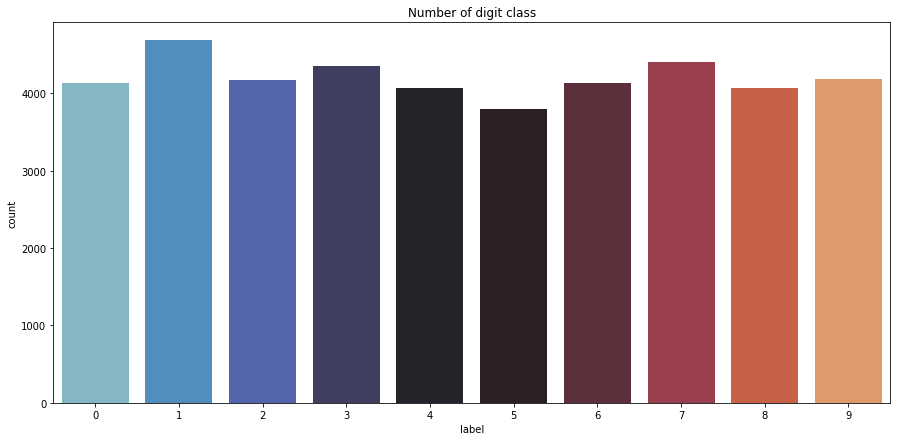

In [5]:
plt.figure(figsize = [15, 7])
sns.countplot(Y_train, palette = 'icefire')
plt.title('Number of digit class')
Y_train.value_counts()

In [6]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X_train.shape

(42000, 784)

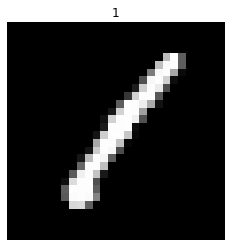

In [8]:
img = X_train.iloc[0]
img = np.array(img).reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[0,0])
plt.axis("off")
plt.show()

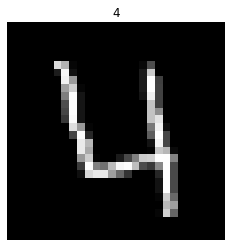

In [10]:
img = X_train.iloc[3]
img = np.array(img).reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[3,0])
plt.axis("off")
plt.show()

In [11]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 784)
test shape:  (28000, 784)


In [12]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [13]:
# Label Encoding 
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

Using TensorFlow backend.


In [14]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (37800, 28, 28, 1)
x_test shape (4200, 28, 28, 1)
y_train shape (37800, 10)
y_test shape (4200, 10)


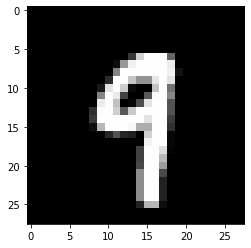

In [15]:
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [17]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [18]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [19]:
epochs = 10  # for better result increase the epochs
batch_size = 250

In [20]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [21]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size)


Epoch 1/10
151/151 [==============================] - 27s 176ms/step - loss: 1.1462 - accuracy: 0.6166 - val_loss: 0.2407 - val_accuracy: 0.9360
Epoch 2/10
151/151 [==============================] - 29s 191ms/step - loss: 0.4551 - accuracy: 0.8567 - val_loss: 0.1551 - val_accuracy: 0.9562
Epoch 3/10
151/151 [==============================] - 26s 173ms/step - loss: 0.3316 - accuracy: 0.8965 - val_loss: 0.1178 - val_accuracy: 0.9662
Epoch 4/10
151/151 [==============================] - 28s 183ms/step - loss: 0.2731 - accuracy: 0.9153 - val_loss: 0.1017 - val_accuracy: 0.9681
Epoch 5/10
151/151 [==============================] - 26s 173ms/step - loss: 0.2490 - accuracy: 0.9232 - val_loss: 0.0866 - val_accuracy: 0.9736
Epoch 6/10
151/151 [==============================] - 26s 174ms/step - loss: 0.2201 - accuracy: 0.9321 - val_loss: 0.0800 - val_accuracy: 0.9731
Epoch 7/10
151/151 [==============================] - 26s 173ms/step - loss: 0.2049 - accuracy: 0.9363 - val_loss: 0.0722 - val_a

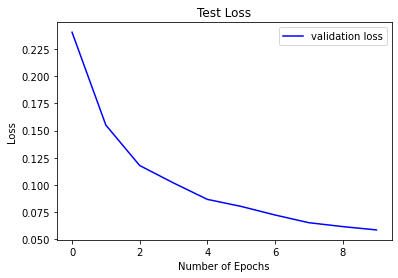

In [22]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

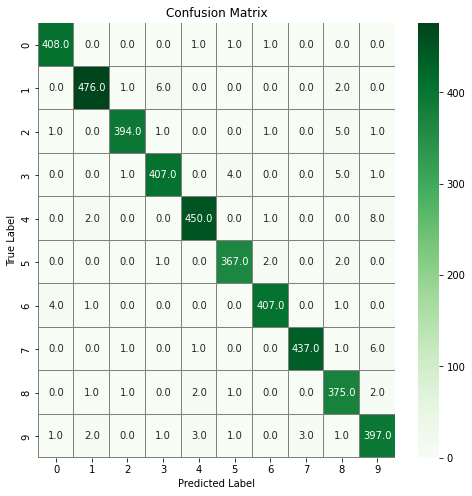

In [23]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [29]:
pred = model.predict(test)

In [31]:
sub = pd.read_csv('/content/sample_submission.csv')
sub['Label'] = pred
sub.to_csv('sub.csv',index=False)